In [18]:
from datascience import *
import pandas as pd
import matplotlib
matplotlib.use('Agg')
from datascience import Table
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use('fivethirtyeight')

# Russell Ranch - Plant Growth Metrics

In [19]:
RR_plant_growth_df = Table().read_table('RR_Plant_Growth_Metrics.csv')

# Remove all N/A values from shoot length
RR_normalized_plant_growth_df = RR_plant_growth_df.where('shoot_length_cm', are.above(0)).to_df()

Man_plant_growth_df = Table().read_table('Man_Plant_Growth_Metrics.csv')

Man_normalized_plant_growth_df = Man_plant_growth_df.where('shoot_length_cm', are.above(0)).to_df()

plant_growth_df = pd.concat([RR_normalized_plant_growth_df, Man_normalized_plant_growth_df])

In [20]:
def plot_plant_growth(data_label, title, x_label, y_label):
    sns.boxplot(x='treatment', y=data_label, data=plant_growth_df, hue='soil')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

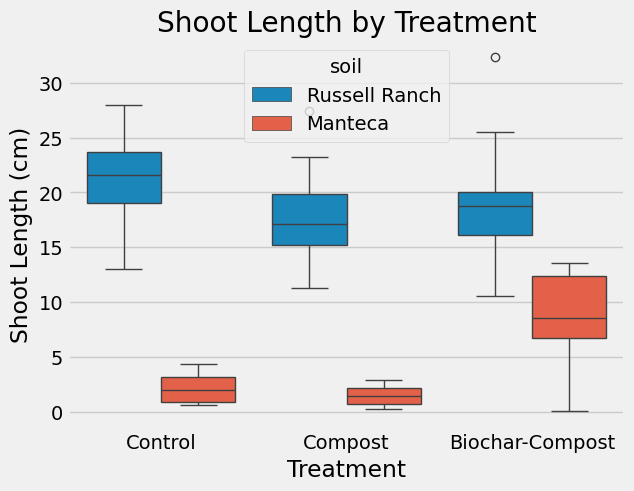

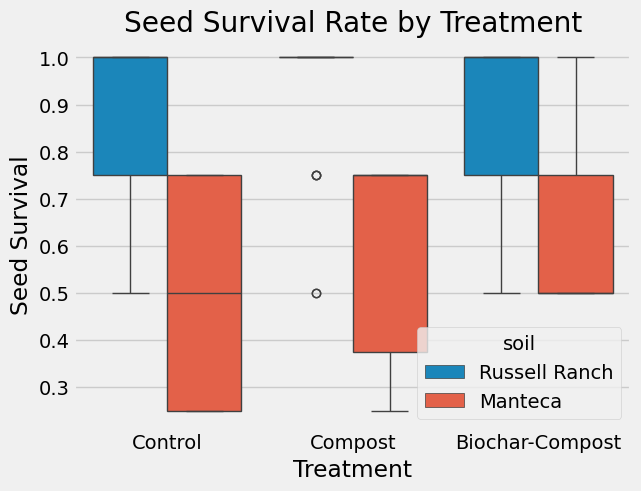

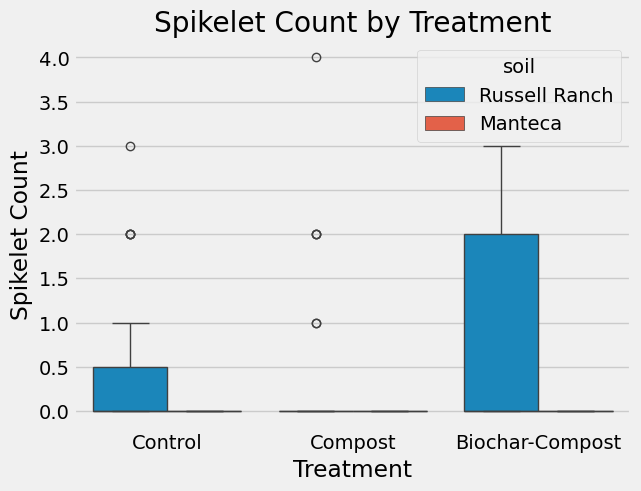

In [21]:
# Shoot length by treatment plot
plot_plant_growth('shoot_length_cm', 'Shoot Length by Treatment', 'Treatment', 'Shoot Length (cm)')

# Seed survival could only be 0, 0.25, 0.5, 0.75, or 1, so graph doesn't seem very useful.
plot_plant_growth('seed_survival_rate', 'Seed Survival Rate by Treatment', 'Treatment', 'Seed Survival')

# Not very significant data
plot_plant_growth('num_spikelets', 'Spikelet Count by Treatment', 'Treatment', 'Spikelet Count')

# Root length + biomass in manteca has null values. think of how to address
# plot_plant_growth('root_length_cm', 'Root Length by Treatment', 'Treatment', 'Root Length (cm)')
# plot_plant_growth('shoot_root_biomass_g', 'Root + Shoot Biomass by Treatment', 'Treatment', 'Root + Shoot Biomass')

In [22]:
RR_chem_properties_df = Table().read_table('RR_Chemical_Properties.csv').to_df()

Man_chem_properties_df = Table().read_table('Man_Chemical_Properties.csv').to_df()

RR_chem_properties_df['category'] = RR_chem_properties_df['Soil'] + '_' + RR_chem_properties_df['Treatment']
Man_chem_properties_df['category'] = Man_chem_properties_df['Soil'] + '_' + Man_chem_properties_df['Treatment']

In [23]:
def plot_chem_properties(data_label, title, x_label, y_label):
    fig, axes = plt.subplots(1, 2, figsize=(12,8))
    
    sns.boxplot(x='Treatment', y=data_label, data=RR_chem_properties_df, hue='Time', ax=axes[0])
    sns.boxplot(x='Treatment', y=data_label, data=Man_chem_properties_df, hue='Time', ax=axes[1])
    axes[0].set_title('Russell Ranch')
    axes[1].set_title('Manteca')
    fig.suptitle(title)
    
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel(y_label)
    
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel(y_label)
    plt.show()

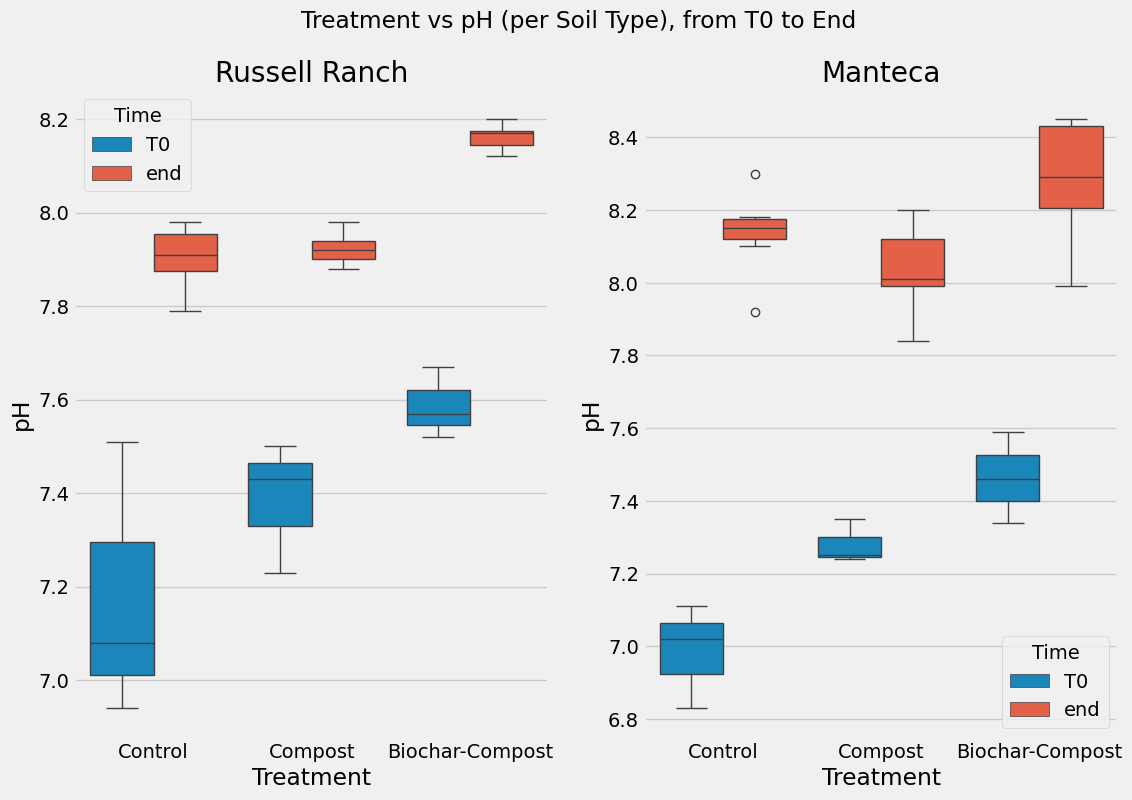

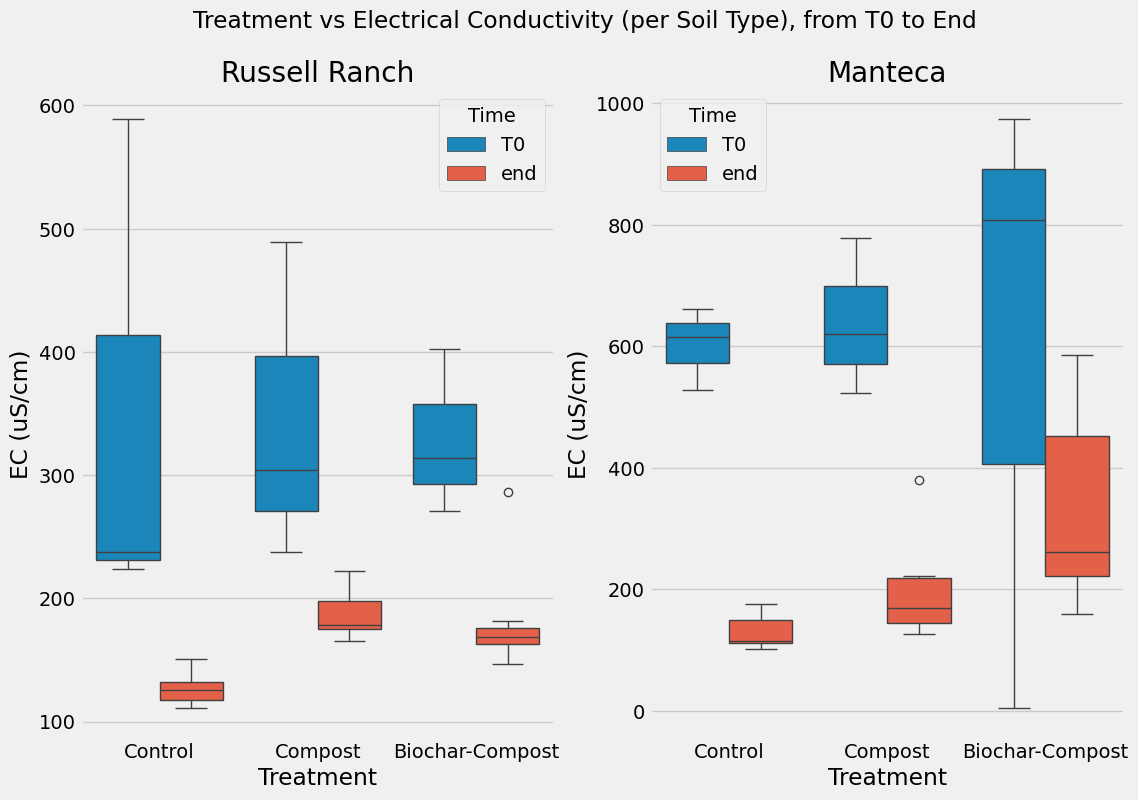

In [24]:
plot_chem_properties('pH', "Treatment vs pH (per Soil Type), from T0 to End", "Treatment", "pH")
plot_chem_properties('EC (uS/cm)', "Treatment vs Electrical Conductivity (per Soil Type), from T0 to End", "Treatment", "EC (uS/cm)")

In [15]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Convert Table to pandas DataFrame
RR_normalized_df = RR_normalized_plant_growth_df.to_df()

# Define your ANOVA model
# Assuming 'shoot_length_cm' is the dependent variable and 'treatment' is the factor
model_shoot_length = ols('shoot_length_cm ~ C(treatment)', data=RR_normalized_df).fit()

# Perform ANOVA
anova_table_shoot_length = sm.stats.anova_lm(model_shoot_length, typ=2)

# Display results
print("ANOVA Table:")
print(anova_table_shoot_length)

AttributeError: 'DataFrame' object has no attribute 'to_df'

The ANOVA table indicates the following:

Sum of Squares (sum_sq):

C(treatment): The variation in shoot_length_cm explained by differences in the treatment groups (133.81).
Residual: The unexplained variation or error (1103.76).
Degrees of Freedom (df):

C(treatment): 2 degrees of freedom (3 treatment groups - 1).
Residual: 68 degrees of freedom (total observations - number of groups).
F-statistic (F):

The F-value (4.12) tests whether the variation among treatment group means is significantly greater than what would be expected by chance.
p-value (PR(>F)):

The p-value (0.020433) indicates the probability of observing this result, assuming the null hypothesis (no difference among treatment means) is true.
Interpretation:
Significance: The p-value is 0.020433, which is below the common threshold of 0.05. Therefore, you can reject the null hypothesis and conclude that there are statistically significant differences in shoot length among the treatment groups.
Next Steps:
Post-hoc Tests:

Perform pairwise comparisons (e.g., Tukey's HSD) to identify which treatments differ significantly.

In [4]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey_shoot_length = pairwise_tukeyhsd(endog=RR_normalized_df['shoot_length_cm'],
                          groups=RR_normalized_df['treatment'],
                          alpha=0.05)
print(tukey_shoot_length)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
        Compost Compost-Biochar   0.8075  0.768 -1.9817 3.5966  False
        Compost         Control   3.2336 0.0191  0.4444 6.0227   True
Compost-Biochar         Control   2.4261   0.11 -0.4206 5.2728  False
---------------------------------------------------------------------


Interpretation of Tukey's HSD Results
Compost vs. Compost-Biochar:

Mean Difference: 0.8075
p-value (p-adj): 0.768
Conclusion: There is no statistically significant difference between the Compost and Compost-Biochar treatments, as the p-value is greater than 0.05.
Compost vs. Control:

Mean Difference: 3.2336
p-value (p-adj): 0.0191
Conclusion: There is a statistically significant difference between the Compost and Control treatments, as the p-value is less than 0.05. The Compost treatment resulted in higher shoot length compared to the Control.
Compost-Biochar vs. Control:

Mean Difference: 2.4261
p-value (p-adj): 0.11
Conclusion: There is no statistically significant difference between the Compost-Biochar and Control treatments, as the p-value is greater than 0.05.
Summary:
The Compost treatment significantly increases shoot length compared to the Control.
No significant differences were observed between Compost and Compost-Biochar or between Compost-Biochar and Control.


In [6]:
#For seed survival
model_seed_survival = ols('seed_survival_rate ~ C(treatment)', data=RR_normalized_df).fit()

# Perform ANOVA
anova_seed_survival = sm.stats.anova_lm(model_seed_survival, typ=2)

# Display results
print("ANOVA Table:")
print(anova_seed_survival)

ANOVA Table:
                sum_sq    df         F    PR(>F)
C(treatment)  0.064593   2.0  1.083474  0.344188
Residual      2.026957  68.0       NaN       NaN


In [7]:
tukey_seed_survival = pairwise_tukeyhsd(endog=RR_normalized_df['seed_survival_rate'],
                          groups=RR_normalized_df['treatment'],
                          alpha=0.05)
print(tukey_seed_survival)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
        Compost Compost-Biochar  -0.0496 0.5834 -0.1691   0.07  False
        Compost         Control  -0.0713 0.3316 -0.1908 0.0482  False
Compost-Biochar         Control  -0.0217 0.9045 -0.1437 0.1002  False
---------------------------------------------------------------------


In [9]:
#Now for num_spikelets
#For seed survival
model_spikelets = ols('num_spikelets ~ C(treatment)', data=RR_normalized_df).fit()

# Perform ANOVA
anova_spikelets = sm.stats.anova_lm(model_spikelets, typ=2)

# Display results
print("ANOVA Table:")
print(anova_spikelets)

ANOVA Table:
                 sum_sq    df         F    PR(>F)
C(treatment)   1.674268   2.0  0.821626  0.444033
Residual      69.283478  68.0       NaN       NaN


In [10]:
tukey_spikelets = pairwise_tukeyhsd(endog=RR_normalized_df['num_spikelets'],
                          groups=RR_normalized_df['treatment'],
                          alpha=0.05)
print(tukey_spikelets)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
        Compost Compost-Biochar   0.3461 0.4651 -0.3527 1.0449  False
        Compost         Control   0.0417 0.9888 -0.6571 0.7405  False
Compost-Biochar         Control  -0.3043 0.5653 -1.0176 0.4089  False
---------------------------------------------------------------------


In [12]:
#Now for root length
model_root_length = ols('root_length_cm ~ C(treatment)', data=RR_normalized_df).fit()
anova_root_length = sm.stats.anova_lm(model_root_length, typ=2)
print("ANOVA Table:")
print(anova_root_length)

ANOVA Table:
                  sum_sq    df         F   PR(>F)
C(treatment)   43.574563   2.0  1.529421  0.22402
Residual      968.690226  68.0       NaN      NaN


In [13]:
tukey_root_length = pairwise_tukeyhsd(endog=RR_normalized_df['root_length_cm'],
                          groups=RR_normalized_df['treatment'],
                          alpha=0.05)
print(tukey_root_length)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
        Compost Compost-Biochar  -0.1563 0.9887 -2.7693 2.4566  False
        Compost         Control  -1.7433 0.2532 -4.3562 0.8696  False
Compost-Biochar         Control   -1.587 0.3334 -4.2538 1.0798  False
---------------------------------------------------------------------


In [15]:
#Now for shoot_root_biomass_g
model_shoot_root_biomass = ols('shoot_root_biomass_g ~ C(treatment)', data=RR_normalized_df).fit()
anova_shoot_root_biomass = sm.stats.anova_lm(model_shoot_root_biomass, typ=2)
print("ANOVA Table:")
print(anova_shoot_root_biomass)

ANOVA Table:
                sum_sq    df         F    PR(>F)
C(treatment)  0.003485   2.0  0.200755  0.818596
Residual      0.590146  68.0       NaN       NaN


In [16]:
tukey_shoot_root_biomass = pairwise_tukeyhsd(endog=RR_normalized_df['shoot_root_biomass_g'],
                          groups=RR_normalized_df['treatment'],
                          alpha=0.05)
print(tukey_shoot_root_biomass)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
        Compost Compost-Biochar  -0.0005 0.9998  -0.065  0.064  False
        Compost         Control   0.0147 0.8482 -0.0498 0.0792  False
Compost-Biochar         Control   0.0152 0.8448 -0.0506  0.081  False
---------------------------------------------------------------------


---------------------

# Manteca - Plant Growth Metrics

In [18]:
Man_plant_growth_df = Table().read_table('Man_Plant_Growth_Metrics.csv')

Man_normalized_plant_growth_df = Man_plant_growth_df.where('shoot_length_cm', are.above(0))

In [21]:
# Convert Table to pandas DataFrame
Man_normalized_df = Man_normalized_plant_growth_df.to_df()

# Define your ANOVA model
# Assuming 'shoot_length_cm' is the dependent variable and 'treatment' is the factor
model_shoot_length = ols('shoot_length_cm ~ C(treatment)', data=Man_normalized_df).fit()

# Perform ANOVA
anova_table_shoot_length = sm.stats.anova_lm(model_shoot_length, typ=2)

# Display results
print("ANOVA Table:")
print(anova_table_shoot_length)

ANOVA Table:
                  sum_sq    df         F    PR(>F)
C(treatment)  369.242139   2.0  17.22064  0.000009
Residual      332.348449  31.0       NaN       NaN


In [22]:
tukey_shoot_length = pairwise_tukeyhsd(endog=Man_normalized_df['shoot_length_cm'],
                          groups=Man_normalized_df['treatment'],
                          alpha=0.05)
print(tukey_shoot_length)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
        Compost Compost-Biochar   6.8043    0.0   3.686  9.9226   True
        Compost         Control   0.6455 0.9204 -3.4445  4.7354  False
Compost-Biochar         Control  -6.1588 0.0012 -9.9855 -2.3321   True
----------------------------------------------------------------------


In [25]:
#For seed survival
model_seed_survival = ols('seed_survival_rate ~ C(treatment)', data=Man_normalized_df).fit()

# Perform ANOVA
anova_seed_survival = sm.stats.anova_lm(model_seed_survival, typ=2)

# Display results
print("ANOVA Table:")
print(anova_seed_survival)

ANOVA Table:
                sum_sq    df         F    PR(>F)
C(treatment)  0.135695   2.0  1.291137  0.289334
Residual      1.629011  31.0       NaN       NaN


In [26]:
tukey_seed_survival = pairwise_tukeyhsd(endog=Man_normalized_df['seed_survival_rate'],
                          groups=Man_normalized_df['treatment'],
                          alpha=0.05)
print(tukey_seed_survival)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
        Compost Compost-Biochar   0.0936 0.5486 -0.1247 0.3119  False
        Compost         Control  -0.0682 0.8286 -0.3545 0.2182  False
Compost-Biochar         Control  -0.1618 0.3113 -0.4297 0.1061  False
---------------------------------------------------------------------


In [29]:
#Now for num_spikelets
#For seed survival
model_spikelets = ols('num_spikelets ~ C(treatment)', data=Man_normalized_df).fit()

# Perform ANOVA
anova_spikelets = sm.stats.anova_lm(model_spikelets, typ=2)

# Display results
print("ANOVA Table:")
print(anova_spikelets)

ANOVA Table:
              sum_sq    df   F  PR(>F)
C(treatment)     NaN   2.0 NaN     NaN
Residual         0.0  31.0 NaN     NaN


/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J


In [30]:
## NO SPIKELETS!!!

In [31]:
#Now for root length
model_root_length = ols('root_length_cm ~ C(treatment)', data=Man_normalized_df).fit()
anova_root_length = sm.stats.anova_lm(model_root_length, typ=2)
print("ANOVA Table:")
print(anova_root_length)

ANOVA Table:
                  sum_sq    df         F    PR(>F)
C(treatment)  537.947506   2.0  7.380786  0.005357
Residual      583.078810  16.0       NaN       NaN


In [32]:
tukey_root_length = pairwise_tukeyhsd(endog=Man_normalized_df['root_length_cm'],
                          groups=RR_normalized_df['treatment'],
                          alpha=0.05)
print(tukey_root_length)

ValueError: data has 34 elements and groups has 71

In [34]:
#Now for shoot_root_biomass_g
model_shoot_root_biomass = ols('shoot_root_biomass_g ~ C(treatment)', data=Man_normalized_df).fit()
anova_shoot_root_biomass = sm.stats.anova_lm(model_shoot_root_biomass, typ=2)
print("ANOVA Table:")
print(anova_shoot_root_biomass)

ANOVA Table:
                sum_sq    df         F    PR(>F)
C(treatment)  0.001641   2.0  8.830635  0.002606
Residual      0.001487  16.0       NaN       NaN


In [35]:
tukey_shoot_root_biomass = pairwise_tukeyhsd(endog=RR_normalized_df['shoot_root_biomass_g'],
                          groups=RR_normalized_df['treatment'],
                          alpha=0.05)
print(tukey_shoot_root_biomass)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
        Compost Compost-Biochar  -0.0005 0.9998  -0.065  0.064  False
        Compost         Control   0.0147 0.8482 -0.0498 0.0792  False
Compost-Biochar         Control   0.0152 0.8448 -0.0506  0.081  False
---------------------------------------------------------------------


--------

# Russell Ranch - pH & EC

In [41]:
RR_chem = Table().read_table('RR_Chemical_Properties.csv')

RR_chem_df = RR_chem.to_df()

# Separate T0 and End data
RR_T0 = RR_chem_df[RR_chem_df["Sample"].str.contains("T0")]
RR_end = RR_chem_df[RR_chem_df["Sample"].str.contains("end")]

In [42]:
from scipy.stats import shapiro, levene

# Normality test (Shapiro-Wilk)
shapiro_T0_pH = shapiro(RR_T0["pH"])[1]
shapiro_end_pH = shapiro(RR_end["pH"])[1]
shapiro_T0_EC = shapiro(RR_T0["EC (uS/cm)"])[1]
shapiro_end_EC = shapiro(RR_end["EC (uS/cm)"])[1]

print(f"Shapiro-Wilk p-values: T0 pH={shapiro_T0_pH}, End pH={shapiro_end_pH}")
print(f"Shapiro-Wilk p-values: T0 EC={shapiro_T0_EC}, End EC={shapiro_end_EC}")

# Homogeneity of variance (Levene’s test)
levene_pH = levene(RR_T0["pH"], RR_end["pH"])[1]
levene_EC = levene(RR_T0["EC (uS/cm)"], RR_end["EC (uS/cm)"])[1]

print(f"Levene's test p-values: pH={levene_pH}, EC={levene_EC}")

Shapiro-Wilk p-values: T0 pH=0.2042985404816237, End pH=0.017759398216109737
Shapiro-Wilk p-values: T0 EC=0.09253696540547979, End EC=0.035010804586366184
Levene's test p-values: pH=0.156835829265078, EC=0.006777792906115233


### non-normal because p>0.05 -> use non-parametric test

In [43]:
from scipy.stats import mannwhitneyu

u_pH, p_mwu_pH = mannwhitneyu(RR_T0["pH"], RR_end["pH"])
u_EC, p_mwu_EC = mannwhitneyu(RR_T0["EC (uS/cm)"], RR_end["EC (uS/cm)"])

print(f"Mann-Whitney U test for pH: U={u_pH}, p={p_mwu_pH}")
print(f"Mann-Whitney U test for EC: U={u_EC}, p={p_mwu_EC}")

Mann-Whitney U test for pH: U=0.0, p=2.0769055090536056e-05
Mann-Whitney U test for EC: U=185.0, p=4.630816293404681e-05


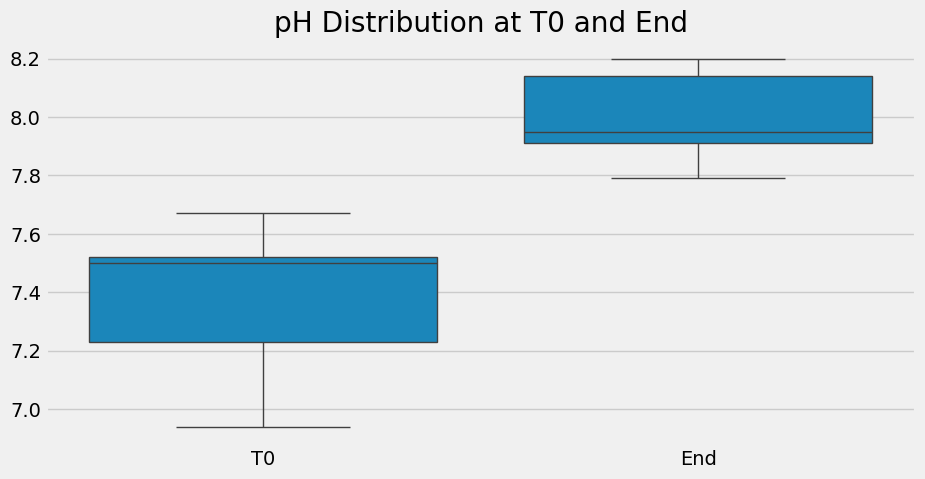

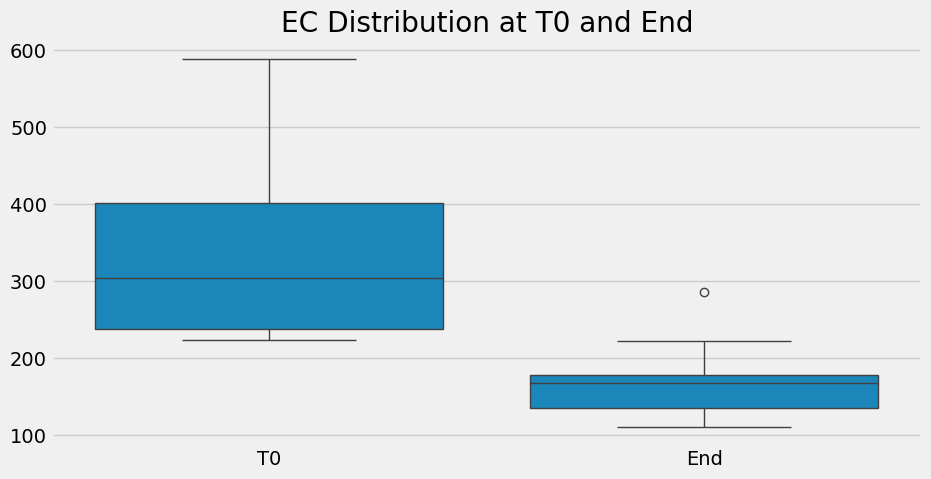

In [44]:
plt.figure(figsize=(10,5))
sns.boxplot(x=["T0"]*len(RR_T0) + ["End"]*len(RR_end), y=RR_T0["pH"].tolist() + RR_end["pH"].tolist())
plt.title("pH Distribution at T0 and End")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x=["T0"]*len(RR_T0) + ["End"]*len(RR_end), y=RR_T0["EC (uS/cm)"].tolist() + RR_end["EC (uS/cm)"].tolist())
plt.title("EC Distribution at T0 and End")
plt.show()

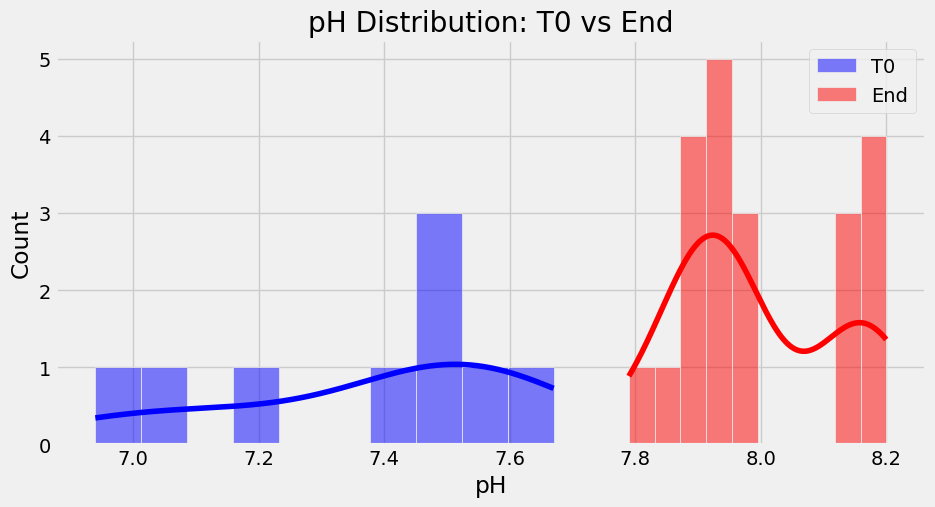

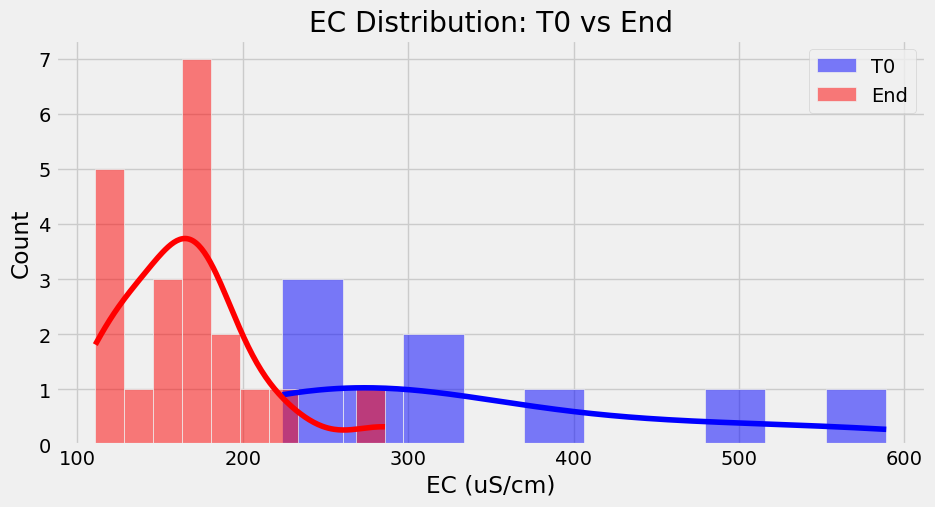

In [45]:
plt.figure(figsize=(10,5))
sns.histplot(RR_T0["pH"], kde=True, color="blue", label="T0", bins=10)
sns.histplot(RR_end["pH"], kde=True, color="red", label="End", bins=10)
plt.legend()
plt.title("pH Distribution: T0 vs End")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(RR_T0["EC (uS/cm)"], kde=True, color="blue", label="T0", bins=10)
sns.histplot(RR_end["EC (uS/cm)"], kde=True, color="red", label="End", bins=10)
plt.legend()
plt.title("EC Distribution: T0 vs End")
plt.show()

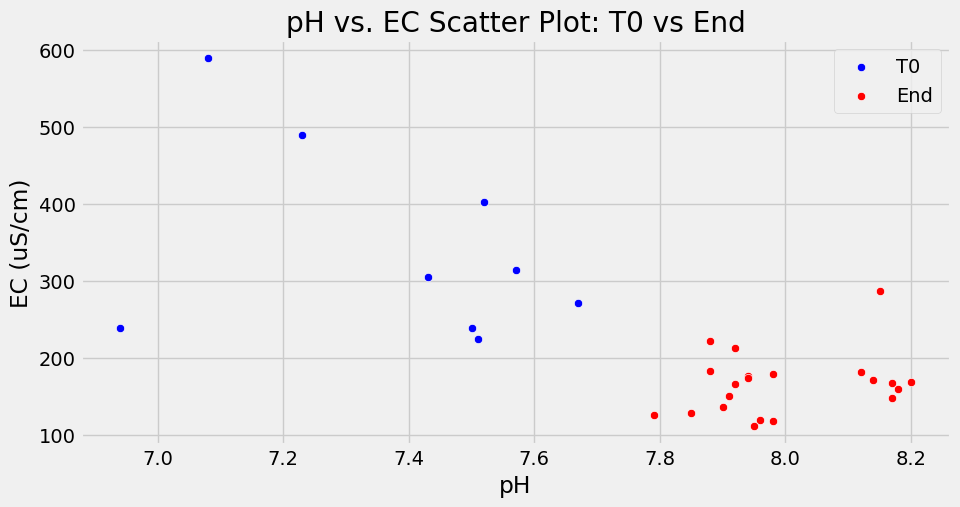

In [46]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=RR_T0["pH"], y=RR_T0["EC (uS/cm)"], color="blue", label="T0")
sns.scatterplot(x=RR_end["pH"], y=RR_end["EC (uS/cm)"], color="red", label="End")
plt.title("pH vs. EC Scatter Plot: T0 vs End")
plt.xlabel("pH")
plt.ylabel("EC (uS/cm)")
plt.legend()
plt.show()


consider running tests separately for ec and ph!!!!!

--------

In [47]:
# Manteca - pH & EC